# Introduction

In this tutorial, we explore how the idempotence-based [Idempotent Test-Time Training (IT3)](https://www.norange.io/projects/ittt/) approach can improve model performance during inference when data is corrupted by Gaussian noise, using the [torch-ttt](https://github.com/nikitadurasov/torch-ttt) *Engine* functionality — specifically the [`IT3Engine`](https://github.com/nikitadurasov/torch-ttt) class.

In [1]:
!pip install git+https://github.com/nikitadurasov/torch-ttt.git

  Cloning https://github.com/nikitadurasov/torch-ttt.git to /tmp/pip-req-build-539tg1nd
  Running command git clone --filter=blob:none --quiet https://github.com/nikitadurasov/torch-ttt.git /tmp/pip-req-build-539tg1nd
  Resolved https://github.com/nikitadurasov/torch-ttt.git to commit 5bd83d5138467c7368b136fcd34e895cfb5ae8f2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Below, we will start by training a networks on MNIST data and demonstrate how susceptible it is to noise introduced during testing, resulting in significantly lower accuracy when the noise is present.

Let’s start with some global parameters that we will use later.

In [2]:
import torch
import torchvision
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

n_epochs = 1  # number of training epochs
batch_size_train = 256  # batch size during training
batch_size_test = 256  # batch size during training
learning_rate = 0.01  # training learning rate

random_seed = 7
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

# Model

We will employ a fairly shallow and simple model, consisting only of several
convolutional and linear layers with LeakyReLU activations.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 10)
        self.activation = nn.LeakyReLU()

    def forward(self, x):
        x = self.activation(F.max_pool2d(self.conv1(x), 2))
        x = self.activation(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x)) + x
        x = self.activation(self.fc3(x)) + x
        x = self.fc4(x)
        return F.softmax(x, dim=-1)

# Data

For training and testing data, we will use the standard train/test MNIST split, which consists of roughly 60,000 samples for training and 10,000 for testing, and we will normalize the data.

In [4]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "./MNIST/",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=batch_size_train,
    shuffle=False,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "./MNIST/",
        train=False,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=batch_size_test,
    shuffle=False,
)

First, let’s visualize 10 random images from the clean MNIST test set. As we can see, the digits are clearly visible and distinctive.

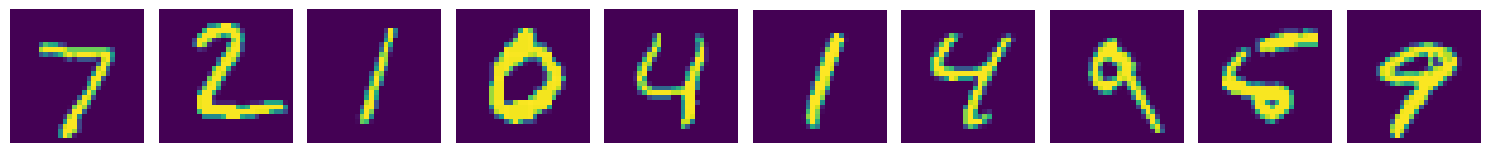

In [5]:
images, _ = next(iter(test_loader))
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for ax, img in zip(axes, images[:10, 0]):
    ax.imshow(img, cmap="viridis")
    ax.axis("off")
plt.tight_layout()
plt.show()


Now, let’s add a significant amount of Gaussian noise to our input images, which will make the classification task significantly more challenging. Let’s plot how they look.

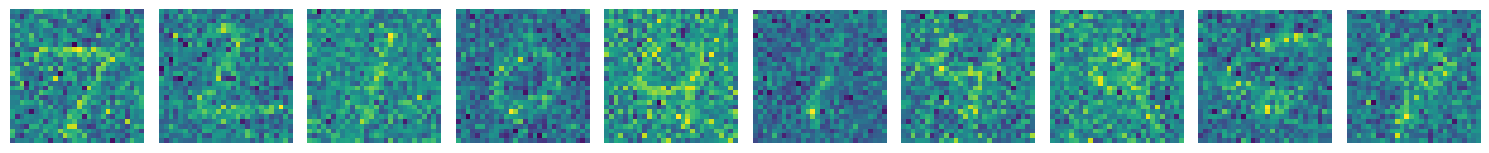

In [6]:
images, _ = next(iter(test_loader))
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for ax, img in zip(axes, images[:10, 0]):
    noisy_img = img + 2 * torch.randn(img.shape)
    ax.imshow(noisy_img, cmap="viridis")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Idempotent Test-Time Training

Now, let’s apply the IT3 approach to enhance performance on noisy inputs. We’ll use the [`IT3Engine`](https://github.com/nikitadurasov/torch-ttt) class, which handles idempotence loss computation and gradient-based optimization during inference.

In [7]:
from torch_ttt.engine.it3_engine import IT3Engine

To integrate IT3 into our existing training and testing pipelines, we only need to add a few lines of code. In the cells below, the creation of the IT3 engine is marked with comments for clarity.

In [8]:
# Create the original model
network = Net()

# Create the engine wrapper that encapsulates all IT3 logic
engine = IT3Engine(

    # Original model
    model=network,

    # The layer to which output features will be added
    features_layer_name="conv1",

    # Distance function used to estimate idempotence between two outputs
    distance_fn=lambda x, y: -torch.sum(y * x, dim=1).mean()
)

# Optimize the engine (which includes TTT logic), not the base model directly
optimizer = optim.Adam(engine.parameters(), lr=1e-3)

## Training

The functions below implement standard training and evaluation loops, adapted to use the IT3 engine. During training, the self-supervised idempotence loss is combined with the classification loss. During testing, the model is evaluated on noisy inputs using IT3's inference-time optimization.


In [9]:
def train():
    engine.train()  # Switch engine to training mode
    correct = 0
    counter = 0
    with tqdm.tqdm(total=len(train_loader), desc="Train") as pbar:
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad()

            # Following the original IT3, pass ground truth as
            # additional input during inference
            one_hot = F.one_hot(target, num_classes=10).float()

            # The engine returns the model output and the
            # self-supervised loss (idempotence in the case of IT3)
            output, loss_ttt = engine(data, target=one_hot)

            loss = (
                F.nll_loss((output + 1e-8).log(), target) + loss_ttt
            )  # Add the self-supervised loss to the total loss

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
            counter += len(data)

            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 10 == 0:
                pbar.update(10)
                pbar.set_postfix(acc=correct / counter)

def ttt_test():
    batch_accs = []
    engine.eval()  # Switch engine to evaluation mode
    correct = 0
    with tqdm.tqdm(total=len(test_loader), desc="Test") as pbar:
        for batch_idx, (data, target) in enumerate(test_loader):
            data += 2 * torch.randn(data.shape)  # Add Gaussian noise to the input
            output, _ = engine(data)  # Run inference with the engine
            pred = output.data.max(1, keepdim=True)[1]
            batch_acc = pred.eq(target.data.view_as(pred)).sum().item()
            batch_accs += [batch_acc / len(target)]
            correct += batch_acc
            if (batch_idx + 1) % 100 == 0:
                pbar.update(100)

        accuracy = 100.0 * correct / len(test_loader.dataset)
        pbar.set_postfix(acc=accuracy)
        return batch_accs


In [10]:
# Run training for 2 epochs
for _ in range(n_epochs+1):
    train()

Train:  98%|█████████▊| 230/235 [00:36<00:00,  6.23it/s, acc=0.968]


## Evaluation

We first evaluate the model without any test-time optimization by setting the number of adaptation steps to zero.  
As we can see, due to the added noise, the model’s accuracy drops significantly.


In [11]:
print("### No optimization ###")
engine.optimization_parameters["num_steps"] = 0
batch_accs_no = ttt_test()

### No optimization ###


Test:   0%|          | 0/40 [00:02<?, ?it/s, acc=76.2]


Next, we enable IT3 by setting the number of optimization steps to 1 and specifying a learning rate.  
This significantly improves performance compared to the non-optimized model on noisy data.

In [12]:
print("### Number of optimization steps: 1 ###")
engine.optimization_parameters["num_steps"] = 1
engine.optimization_parameters["lr"] = 1e-3
batch_accs_o = ttt_test()

### Number of optimization steps: 1 ###


Test:   0%|          | 0/40 [00:07<?, ?it/s, acc=82.9]


The boxplot below compares the model’s performance on noisy data with and without IT3 adaptation.  
IT3 optimization leads to a clear improvement in accuracy, showing its effectiveness in mitigating corruption-induced degradation.

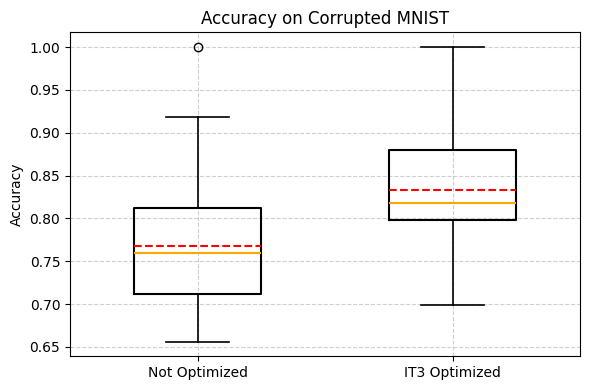

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

plt.boxplot(
    [batch_accs_no, batch_accs_o],
    widths=0.5,
    meanline=True,
    showmeans=True,
    boxprops=dict(linewidth=1.5),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    medianprops=dict(linewidth=1.5, color='orange'),
    meanprops=dict(linewidth=1.5, color='red')
)

plt.xticks([1, 2], ['Not Optimized', 'IT3 Optimized'])
plt.title("Accuracy on Corrupted MNIST")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
